In [2]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
import cv2
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import tensorflow as tf
from data import *
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [2]:
model = ResNet50(weights='imagenet')

In [15]:
## Labels ##
# dic_labels = {}

# files = open('dataset/labels_satellite/labels_classifier.txt')
# lines = files.readlines()

# for line in lines:
#     name, label = line.split(' ')
#     name = name.rstrip('.jpg')
#     label = int(label.rstrip('\n'))
#     dic_labels[name + '.png'] = label
# print(dic_labels)

In [57]:
## Data ## 

folder = 'dataset/images_satellite'

onlyfiles = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

# print("Working with {0} images".format(len(onlyfiles)))
print("Image examples:")

# Print one of the examples
# print(onlyfiles[0])
file_path = folder +"/" + onlyfiles[0]
print(file_path)
# print(len(onlyfiles))

def preprocess(file_path):
    img = image.load_img(file_path)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    return x

def image_preprocess(folder):
    onlyfiles = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
    target_height = 300
    target_width = 300
    inputs = np.zeros((len(onlyfiles), target_height, target_width, 3))
    
    for i in range(0, len(onlyfiles)):
        file_path = folder + "/" + onlyfiles[i]
        img = preprocess(file_path)
        inputs[i,:,:,:] = img
    return inputs,  len(onlyfiles)


inputs_pos, shape = image_preprocess('dataset/images_satellite')
inputs_neg, shape_neg = image_preprocess('dataset/images_unburnt')
image_test, _ = image_preprocess('dataset/test_images')
print(inputs_pos.shape)
print(inputs_neg.shape)

Image examples:
dataset/images_satellite/2MSI_20200110_S2.png
(27, 300, 300, 3)
(8, 300, 300, 3)


In [45]:
# %%bash
# cd dataset
# mkdir test_augmented

In [58]:
# datagen = ImageDataGenerator(
#         rotation_range=20,
#         horizontal_flip=True,
#         vertical_flip=True)

# i = 0
# for batch in datagen.flow(image_test, batch_size=1,
#                           save_to_dir='dataset/test_augmented', save_format='jpg'):
#     i += 1
#     if i > 30:
#         break  

In [35]:
inputs_pos, shape = image_preprocess('dataset/images_augmented')
inputs_neg, shape_neg = image_preprocess('dataset/images_unburnt_augmented')
print(inputs_pos.shape)
print(inputs_neg.shape)

inputs = np.concatenate((inputs_pos,inputs_neg), axis=0)
print(inputs.shape)
      
labels = np.zeros(inputs.shape[0])
labels[:shape] = 1
print(labels[:shape].shape)
# print(labels)

(448, 300, 300, 3)
(127, 300, 300, 3)
(575, 300, 300, 3)
(448,)


In [60]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# create the base pre-trained model
base_model = ResNet50(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 2 classes
predictions = Dense(2, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:165]:
   layer.trainable = False
for layer in model.layers[165:]:
   layer.trainable = True

model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history = model.fit(inputs,labels,batch_size=3, epochs=5, verbose=1, validation_split = 0.2, shuffle = True)

0 input_18
1 conv1_pad
2 conv1_conv
3 conv1_bn
4 conv1_relu
5 pool1_pad
6 pool1_pool
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_conv
11 conv2_block1_2_bn
12 conv2_block1_2_relu
13 conv2_block1_0_conv
14 conv2_block1_3_conv
15 conv2_block1_0_bn
16 conv2_block1_3_bn
17 conv2_block1_add
18 conv2_block1_out
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_conv
23 conv2_block2_2_bn
24 conv2_block2_2_relu
25 conv2_block2_3_conv
26 conv2_block2_3_bn
27 conv2_block2_add
28 conv2_block2_out
29 conv2_block3_1_conv
30 conv2_block3_1_bn
31 conv2_block3_1_relu
32 conv2_block3_2_conv
33 conv2_block3_2_bn
34 conv2_block3_2_relu
35 conv2_block3_3_conv
36 conv2_block3_3_bn
37 conv2_block3_add
38 conv2_block3_out
39 conv3_block1_1_conv
40 conv3_block1_1_bn
41 conv3_block1_1_relu
42 conv3_block1_2_conv
43 conv3_block1_2_bn
44 conv3_block1_2_relu
45 conv3_block1_0_conv
46 conv3_block1_3_conv
47 conv3_block1_0_bn
48 conv3_block1_3_b

In [61]:
img_test, _ = image_preprocess('dataset/test_augmented')
# print(img_test.shape)
prediction = model.predict(img_test)
prediction[prediction>0.5] = 1
prediction[prediction<0.5] = 0
# print(prediction.shape)
idx = np.where(prediction[:,0] == 0)
# print(len(idx[0]))
print('accuracy:' , 1 - float(len(idx[0]))/float(prediction.shape[0]))

accuracy: 0.967741935483871


In [4]:
# np.save('my_history.npy',history.history)
# model.save_weights("classifier.h5")
history=np.load('my_history.npy',allow_pickle='TRUE').item()

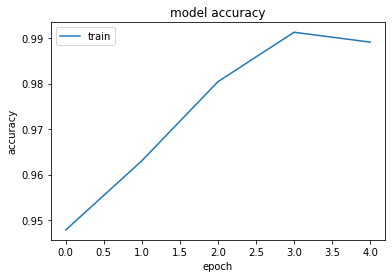

In [5]:
plt.plot(history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

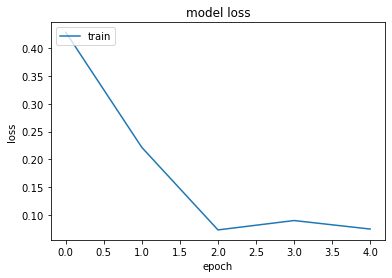

In [7]:
plt.plot(history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()